In [ ]:
!wget "https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731" -O image.jpeg

--2025-04-01 03:21:31--  https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731
Resolving service.archief.nl (service.archief.nl)... 195.169.53.74, 2001:610:1e0::2:adf:ff4a
Connecting to service.archief.nl (service.archief.nl)|195.169.53.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg              [    <=>             ]   1.16M  1.20MB/s    in 1.0s    

2025-04-01 03:21:33 (1.20 MB/s) - ‘image.jpeg’ saved [1219191]



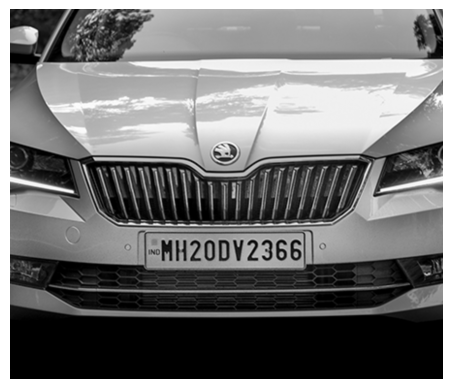

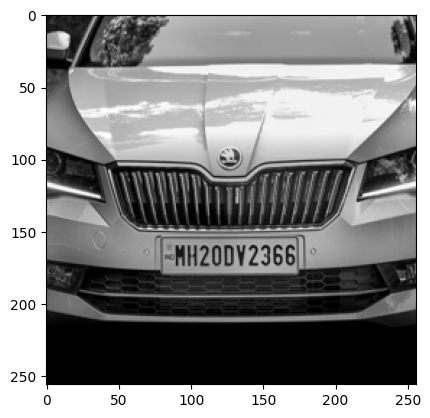

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('image.jpeg', cv2.IMREAD_GRAYSCALE)

# Define cropping coordinates
x, y, w, h = 100, 220, 1024, 1024
img = img[y:y+h, x:x+w]

# Show cropped image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Resize image to 256x256
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

# Show resized image
plt.imshow(img, cmap='gray')
plt.show()

original_img = img.copy()

## k_init is random but not changing

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=50):
    """
    Perform Richardson-Lucy blind deconvolution to estimate both x and k.

    Parameters:
    y : np.array
        Blurred image
    k_init : np.array
        Initial guess for the blur kernel
    num_iter : int
        Number of iterations to run

    Returns:
    x_est : np.array
        Estimated sharp image
    k_est : np.array
        Estimated blur kernel
    """

    x_est = np.copy(y)  # Initialize x as y
    k_est = np.copy(k_init)  # Initial kernel guess

    for i in range(num_iter):
        # Compute blurred estimate of x
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_x = y / (x_blurred + 1e-8)
        x_est *= convolve2d(relative_blur_x, k_est[::-1, ::-1], mode='same', boundary='wrap')

        # Compute blurred estimate of k
        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_k = y / (k_blurred + 1e-8)
        k_update = convolve2d(x_est[::-1, ::-1], relative_blur_k, mode='valid', boundary='wrap')

        # Normalize the kernel to sum to 1
        k_est *= k_update
        k_est /= np.sum(k_est)

    return x_est, k_est

def evaluate2(num_iter, x, y, k_init):
    # Perform blind deconvolution
    x_recovered, k_recovered = richardson_lucy_blind_deconvolution(y, k_init, num_iter)

    # PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    print("Recovered x from frequency domain:", np.round(x_recovered))
    print("MSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Display results
    plt.figure(figsize=(20, 10))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(x_recovered, cmap='gray'), plt.title("Recovered Image")
    plt.show()

    print("Recovered Kernel:")
    print(k_recovered)

    return psnr_recovery

# Define Gaussian blur kernel
sigma = 10000
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)
k /= k.sum()

# Load an example image (grayscale 256x256)
x = img  # Assuming 'img' is a 256x256 image

# Generate blurred image
y = convolve2d(x, k, mode='same', boundary='wrap')

# Initialize the kernel estimate, for a fixed seed
np.random.seed(0)
k_init = np.abs(np.random.rand(*k.shape))
k_init /= np.sum(k_init)

iters = np.logspace(0.5, 4, num=30, dtype=int)  # 30 values between 10^0.5 and 10^4
print(iters)
psnr_values = []

for num_iter in iters:
    print(num_iter)
    psnr = evaluate2(num_iter, x, y, k_init)
    psnr_values.append(psnr)

plt.figure(figsize=(8, 5))
plt.plot(iters, psnr_values, marker='o', linestyle='-', color='b')
plt.xscale("log")  # Use log scale
plt.xlabel("Number of Iterations")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Trend with Iterations")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [4]:
import numpy as np

sigma = 10000
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)
k /= k.sum()
print(k)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


## k_init is random and changing

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=50):
    """
    Perform Richardson-Lucy blind deconvolution to estimate both x and k.

    Parameters:
    y : np.array
        Blurred image
    k_init : np.array
        Initial guess for the blur kernel
    num_iter : int
        Number of iterations to run

    Returns:
    x_est : np.array
        Estimated sharp image
    k_est : np.array
        Estimated blur kernel
    """

    x_est = np.copy(y)  # Initialize x as y
    k_est = np.copy(k_init)  # Initial kernel guess

    for i in range(num_iter):
        # Compute blurred estimate of x
        x_blurred = convolve2d(x_est, k_est, )
        relative_blur_x = y / (x_blurred + 1e-8)
        x_est *= convolve2d(relative_blur_x, k_est[::-1, ::-1], )

        # Compute blurred estimate of k
        k_blurred = convolve2d(x_est, k_est,)
        relative_blur_k = y / (k_blurred + 1e-8)
        k_update = convolve2d(x_est[::-1, ::-1], relative_blur_k, mode='valid', boundary='wrap')

        # Normalize the kernel to sum to 1
        k_est *= k_update
        k_est /= np.sum(k_est)

    return x_est, k_est

def evaluate2(num_iter, x, y, k_init):
    # Perform blind deconvolution
    x_recovered, k_recovered = richardson_lucy_blind_deconvolution(y, k_init, num_iter)

    # PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    print("Recovered x from frequency domain:", np.round(x_recovered))
    print("MSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Display results
    plt.figure(figsize=(20, 10))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(x_recovered, cmap='gray'), plt.title("Recovered Image")
    plt.show()

    print("Recovered Kernel:")
    print(k_recovered)

    return psnr_recovery

# Define Gaussian blur kernel
sigma = 5
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)
k /= k.sum()

# Load an example image (grayscale 256x256)
x = img  # Assuming 'img' is a 256x256 image

# Generate blurred image
y = convolve2d(x, k, mode='same', boundary='wrap')

# Initialize the kernel estimate, for a fixed seed
# np.random.seed(0)
k_init = np.abs(np.random.rand(*k.shape))
k_init /= np.sum(k_init)

iters = np.logspace(0.5, 5, num=35, dtype=int)  # 35 values between 10^0.5 and 10^5
psnr_values = []
print(iters)

for num_iter in iters:
    print(num_iter)
    psnr = evaluate2(num_iter, x, y, k_init)
    psnr_values.append(psnr)

plt.figure(figsize=(8, 5))
plt.plot(iters, psnr_values, marker='o', linestyle='-', color='b')
plt.xscale("log")  # Use log scale
plt.xlabel("Number of Iterations")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Trend with Iterations")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()























Output hidden; open in https://colab.research.google.com to view.